# Code to load spike times for t-maze trials, calculate theta phase, and average phase by t-maze sector

### Load spikes from t-maze trials

In [1]:
# Set system path to allow ephys class import
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from ephys import *
from ephys_utils import *

obj = ephys(recording_type = 'nexus', path = '/home/isabella/Documents/isabella/jake/recording_data/r1364/2023-06-14')

obj.load_spikes('good')

# Select only spikes from t-maze trials
t_maze_trials = [i for i, s in enumerate(obj.trial_list) if 't-maze' in s]
obj.t_maze_spikes = select_spikes_by_trial(obj.spike_data, t_maze_trials, obj.trial_offsets)

print(f"Spikes loaded from {len(t_maze_trials)} t-maze trial(s)")

Spikes loaded from 2 t-maze trial(s)


### Calculate theta phase and position sector for spikes in each cluster

In [3]:
from position_analysis import *

## Load LFP for each channel with good units
lfp_sampling_rate = 1000
pos_sample_rate = 50
peakFreq = 6

# Get unique channels where good units are found
good_channels = list(sorted(set(obj.spike_data['cluster_channels'].values())))
good_channels = [str(i) for i in good_channels]

# Initialise output variables
obj.cluster_phases = {}
obj.cluster_sectors = {}

# Load LFP and position for each channel, get theta phase and position sector for each spike
for i in t_maze_trials:
    # Load lfp
    obj.load_lfp(i, lfp_sampling_rate, 0, 600, good_channels, reload_flag = False)
    
    # Load position, get pos timestamps
    obj.load_pos(i, reload_flag = True) #Needs reloading each time for now
    trial_pos = obj.pos_data[i]['xy_position']
    pos_timestamps = obj.pos_data[i]['xy_position'].columns.values / pos_sample_rate
    trial_pos.columns = pos_timestamps
    
    # Convert to DataFrame and rename columns to match original channel
    lfp_df = pd.DataFrame(obj.lfp_data[1]['data'])
    lfp_df.columns = good_channels
    
    # Cut any spike times out of the time range of the LFP
    mask = obj.t_maze_spikes[i]['spike_times'] < max(obj.lfp_data[i]['timestamps'])
    spike_times_good = obj.t_maze_spikes[i]['spike_times'][mask]
    spike_clusters_good = obj.t_maze_spikes[i]['spike_clusters'][mask.flatten()]
    
    # Loop through each good cluster
    for cluster, channel in obj.spike_data['cluster_channels'].items():
        ## SPIKE PHASE
        # Extract LFP data for the recording channel
        lfp_data_for_channel = lfp_df.loc[:,str(channel)]
        
        # Extract spike times for the cluster
        cluster_spike_times = spike_times_good[spike_clusters_good == cluster]
        
        # Compute theta phases for the spike times
        spike_phases = get_theta_phase(lfp_data_for_channel, cluster_spike_times, lfp_sampling_rate, peakFreq)
        
        # Store in the dictionary
        obj.cluster_phases[cluster] = spike_phases    
        
        ## SPIKE POSITION SECTOR
        # Assign spike times to nearest position sector
        spike_pos = [[], []]
        for t in cluster_spike_times:
            spike_pos_index = round(t * 50)/50
            spike_pos[0].append(trial_pos[spike_pos_index].values[0])
            spike_pos[1].append(trial_pos[spike_pos_index].values[1])
        
        # spike_pos is now an array with the structure  [[x1, x2, x3 ...], [y1, y2, y3 ...]] for each spike
        # Get position sector for each spike
        spike_sectors = assign_sectors(pd.DataFrame(spike_pos))
        
        # add sectors to dict
        obj.cluster_sectors[cluster] = spike_sectors
        

LFP data already loaded for trial 1
Loading pos file: /home/isabella/Documents/isabella/jake/recording_data/r1364/2023-06-14/230614_r1364_raw_t-maze_1.pos
147 LED swaps detected and fixed
Loading pos file: /home/isabella/Documents/isabella/jake/recording_data/r1364/2023-06-14/230614_r1364_raw_t-maze_2.pos
95 LED swaps detected and fixed


### Theta phase polar plots by position sector for whole recording session

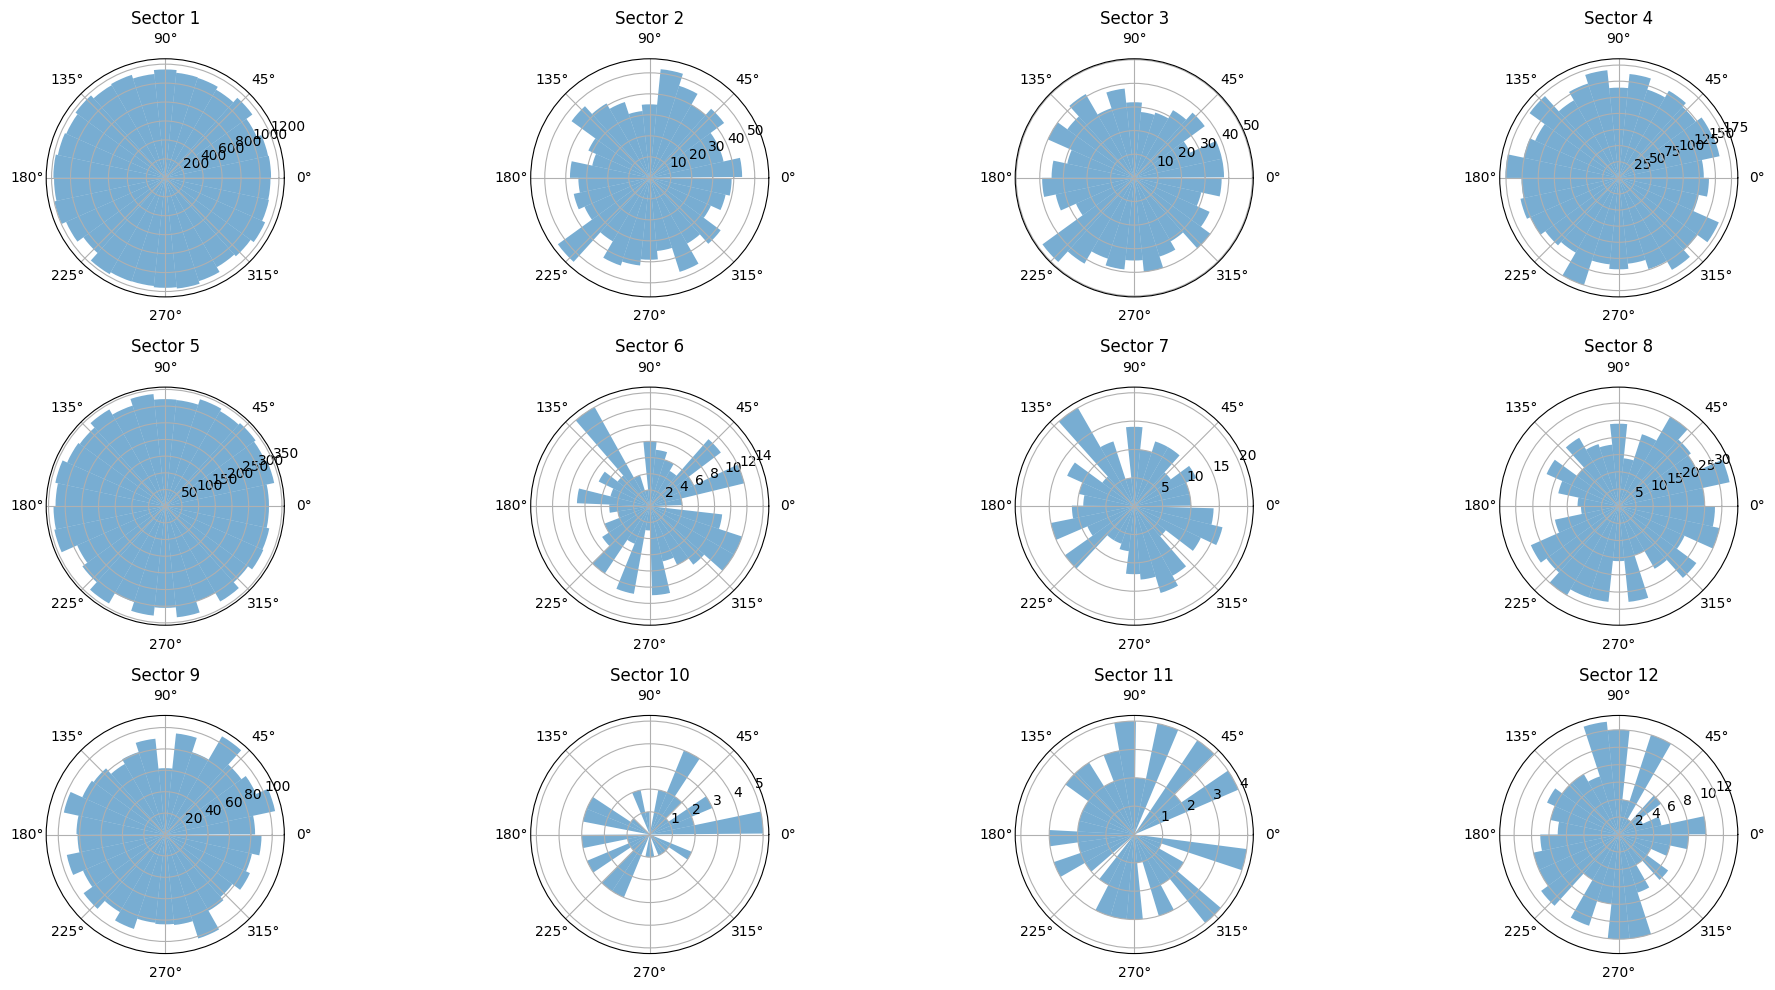

In [35]:
from scipy.stats import circmean, circvar

# Function to get phases for a given sector
def get_phases_for_sector(cluster_sectors, cluster_phases, sector):
    all_phases = []
    for cluster_id in cluster_sectors:
        indices = np.where(cluster_sectors[cluster_id] == sector)[0]
        all_phases.extend(cluster_phases[cluster_id][indices])
    return all_phases

# Compute circular mean and variance for each sector
sector_means = {}
sector_vars = {}

unique_sectors = range(1,13)

for sector in unique_sectors:
    phases = get_phases_for_sector(obj.cluster_sectors, obj.cluster_phases, sector)
    sector_means[sector] = circmean(phases, high=2*np.pi, low=0, nan_policy = 'omit')
    sector_vars[sector] = circvar(phases, high=2*np.pi, low=0, nan_policy = 'omit')

# Create polar plots for each sector
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 10), subplot_kw={'projection': 'polar'})
axes = axes.ravel()

for i, sector in enumerate(unique_sectors):
    phases = get_phases_for_sector(obj.cluster_sectors, obj.cluster_phases, sector)
    # Histogram of the phases
    n, bins, patches = axes[i].hist(phases, bins=30, alpha=0.6)
    # Set the title for the current subplot
    axes[i].set_title(f"Sector {sector}")

plt.tight_layout()
plt.show()

### Individual cell theta phase plots by position sector

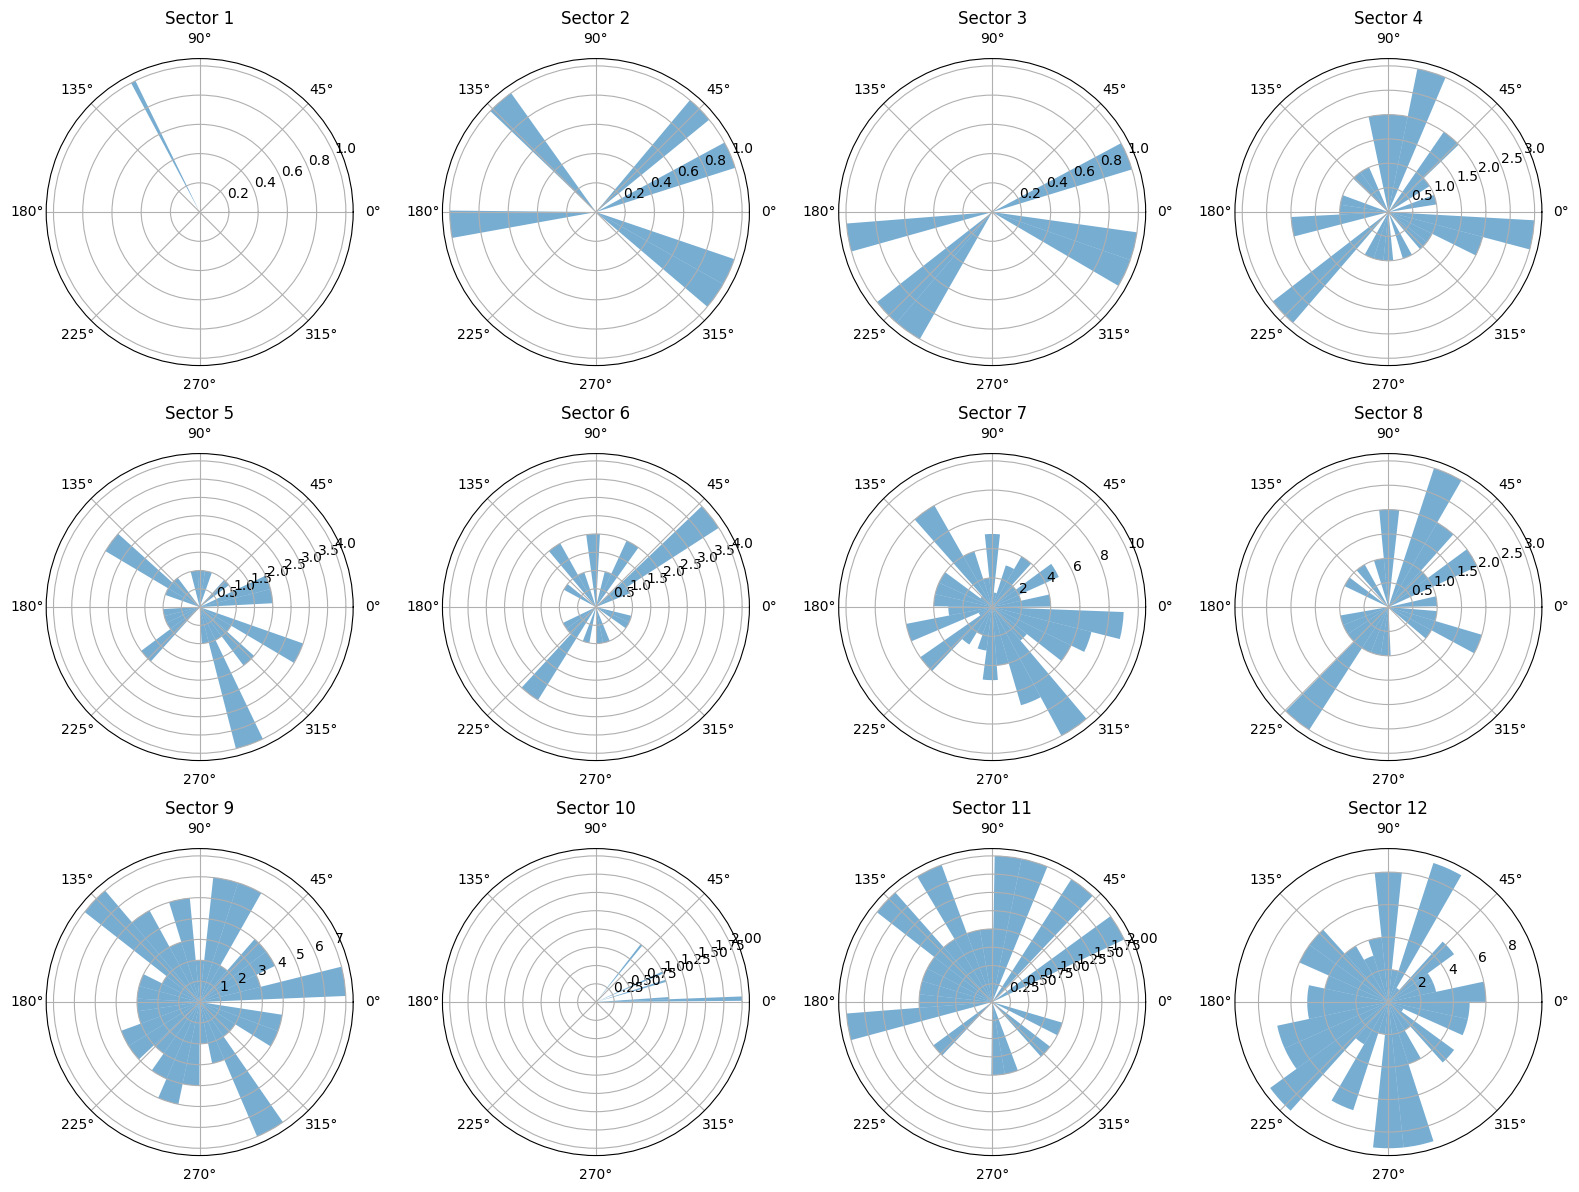

In [36]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Function to get phases for a given sector within a specific cluster
def get_phases_for_sector_in_cluster(cluster_sectors, cluster_phases, sector, cluster_id):
    indices = np.where(cluster_sectors[int(cluster_id)] == sector)[0]
    return cluster_phases[int(cluster_id)][indices]

# Function to plot polar plots for a specific cluster
def plot_cluster(cluster_id):
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12), subplot_kw={'projection': 'polar'})
    
    for idx, sector in enumerate(unique_sectors):
        row_idx = idx // 4
        col_idx = idx % 4
        sector = int(sector)
        
        phases = get_phases_for_sector_in_cluster(obj.cluster_sectors, obj.cluster_phases, sector, cluster_id)
        
        # Histogram of the phases
        n, bins, patches = axes[row_idx, col_idx].hist(phases, bins=30, alpha=0.6)
        # Set the title for the current subplot
        axes[row_idx, col_idx].set_title(f"Sector {sector}")

    plt.tight_layout()
    plt.show()

# Create a widget to allow user to click through clusters
def on_button_click(b):
    clear_output(wait=True)
    plot_cluster(b.description)
    display(widget_container)

buttons = [widgets.Button(description=str(cluster_id)) for cluster_id in obj.cluster_sectors.keys()]
for button in buttons:
    button.on_click(on_button_click)

widget_container = widgets.HBox(buttons)
display(widget_container)

### Plot sample EEG section raw, filtered, and Hilbert transformed

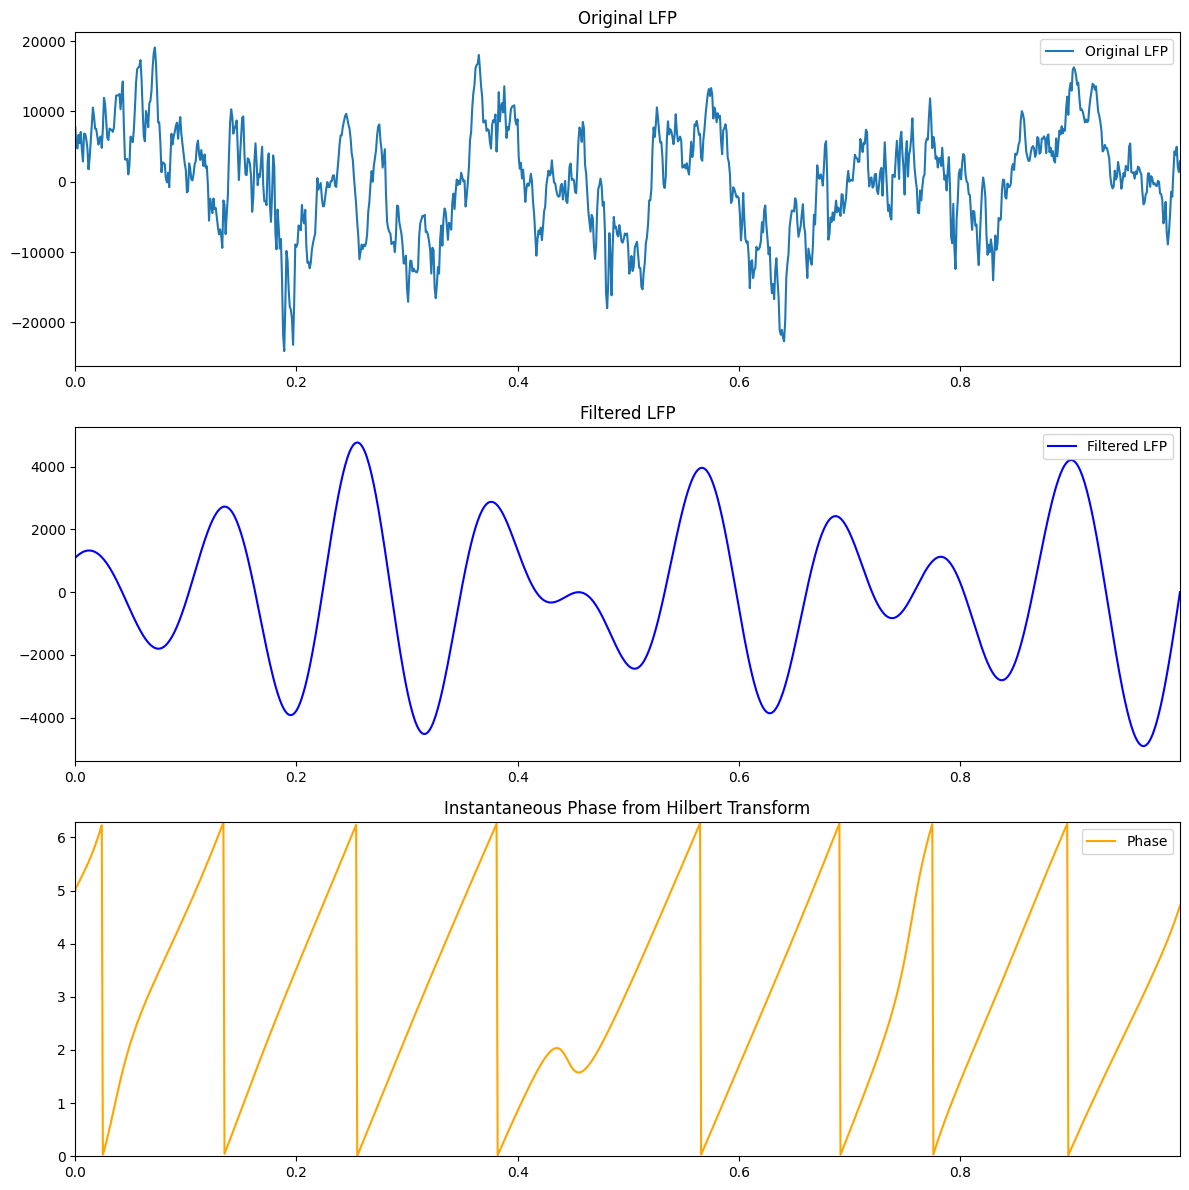

In [37]:
import matplotlib.pyplot as plt
def plot_lfp_and_hilbert(lfp, sampling_rate, peakFreq, filtHalfBandWidth):
    """
    Plot the LFP and its Hilbert transform.

    Parameters:
    - lfp: Local Field Potential time series.
    - sampling_rate: The sampling rate of the LFP.
    - peakFreq: The central frequency around which the LFP is filtered.
    - filtHalfBandWidth: Half bandwidth for filtering. Default is 3 Hz.
    
    Returns:
    - A plot displaying the LFP, its filtered version, and the phase from the Hilbert transform.
    """
    
    # Create a time vector
    t = np.arange(0, len(lfp)/sampling_rate, 1/sampling_rate)
    
    # FILTER THE LFP AROUND THE PEAK FREQUENCY
    low = (peakFreq - filtHalfBandWidth)
    high = (peakFreq + filtHalfBandWidth)
    taps = firwin(round(sampling_rate) + 1, [low, high], pass_zero=False, window='blackman', fs=sampling_rate)
    padlen = min(3 * (len(taps) - 1), len(lfp) - 1)
    theta_lfp = filtfilt(taps, 1, lfp, padlen=padlen)

    # Extract instantaneous phase using Hilbert transform
    analytic_signal = hilbert(theta_lfp)
    eegPhase = np.angle(analytic_signal)
    eegPhase = np.mod(eegPhase, 2 * np.pi)
    
    # Plot
    fig, ax = plt.subplots(3, 1, figsize=(12, 12))

    # Plot the original LFP
    ax[0].plot(t, lfp, label='Original LFP')
    ax[0].set_title('Original LFP')
    ax[0].set_xlim([0, t[-1]])
    ax[0].legend()

    # Plot the filtered LFP
    ax[1].plot(t, theta_lfp, label='Filtered LFP', color='blue')
    ax[1].set_title('Filtered LFP')
    ax[1].set_xlim([0, t[-1]])
    ax[1].legend()

    # Plot the instantaneous phase
    ax[2].plot(t, eegPhase, label='Phase', color='orange')
    ax[2].set_title('Instantaneous Phase from Hilbert Transform')
    ax[2].set_xlim([0, t[-1]])
    ax[2].set_ylim([0, 2 * np.pi])
    ax[2].legend()

    plt.tight_layout()
    plt.show()

plot_lfp_and_hilbert(lfp_data_for_channel[8000:9000], sampling_rate = lfp_sampling_rate, peakFreq = 8, filtHalfBandWidth = 2)